In [1]:
from pathlib import Path
import matplotlib.pyplot as plt

parent_directory = str(Path().resolve().parent)
parent_directory

import os,sys 
script_path = os.path.abspath("../src")  # Adjust the path
sys.path.append(script_path)
print(parent_directory)
import base_strategies

/Users/yiminglin/Documents/Codebase/doc-provenance


[nltk_data] Downloading package punkt to /Users/yiminglin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
import json 
import tiktoken

def read_json(path):
    if not os.path.exists(path):
        return None
    with open(path, "r", encoding="utf-8") as file:
        data = json.load(file)
    return data

def count_tokens(text, model="gpt-4o-mini"):
    encoder = tiktoken.encoding_for_model(model)  # Get the tokenizer for the specific model
    tokens = encoder.encode(text)  # Encode text into tokens
    return len(tokens)

In [12]:
#paper dataset 
data_path = parent_directory + '/out/papers/results/'
strategies = ['vallina_LLM','sequential_greedy','divide_and_conquer','heuristic_greedy','heuristic_topk','exponential_greedy']

doc_num = 4
q_num = 3
runs = {}
for d_id in range(doc_num):
    for q_id in range(q_num):
        #this is one run 
        for strategy in strategies:
            file_path = data_path + 'doc' + str(d_id) + '_q' + str(q_id) + '_' + strategy + '.json'
            result = read_json(file_path)
            if(result == None):
                continue
            if strategy not in runs:
                runs[strategy] = []
            runs[strategy].append(result) 




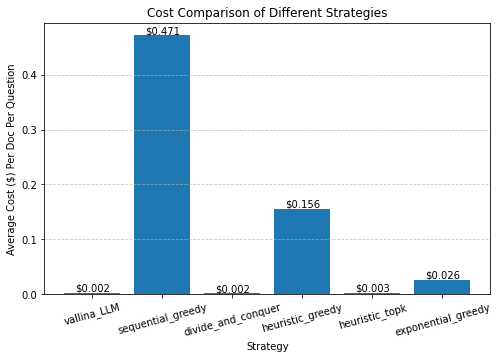

In [13]:
#cost

y = {}
input_cost_unit = 0.15/1000000
output_cost_unit = 0.6/1000000

for strategy in strategies:
    total_input_tokens = 0
    total_output_tokens = 0
    for o in runs[strategy]:
        tokens = o['tokens']
        total_input_tokens += tokens[0]
        total_output_tokens += tokens[1]
    #compute cost 
    total_cost = total_input_tokens*input_cost_unit + total_output_tokens*output_cost_unit
    y[strategy] = total_cost/len(runs[strategy])

# Extracting x (strategies) and y (costs)
strategies = ['vallina_LLM','sequential_greedy','divide_and_conquer','heuristic_greedy','heuristic_topk','exponential_greedy']
y_values = [y[strategy] for strategy in strategies]

# Plotting the bar chart with value labels
plt.figure(figsize=(8, 5))
bars = plt.bar(strategies, y_values)

# Adding labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'${yval:.3f}', ha='center', va='bottom', fontsize=10)

# Adding labels and title
plt.xlabel("Strategy")
plt.ylabel("Average Cost ($) Per Doc Per Question")
plt.title("Cost Comparison of Different Strategies")

# Rotate x labels for better readability
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig(parent_directory + "/out/papers/plots/cost_gpt4omini.jpg", dpi=300, bbox_inches='tight')
# Show plot
plt.show()

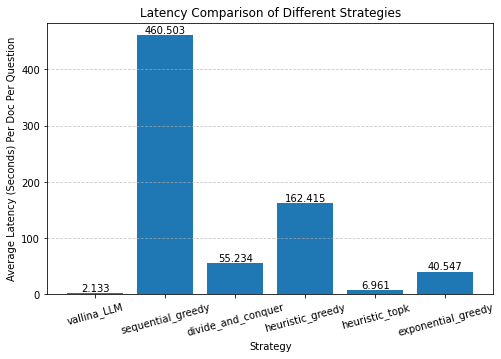

In [17]:
#latency

y = {}

for strategy in strategies:
    total_time = 0
    c = 0
    for o in runs[strategy]:
        c+=1
        if('time' not in o):
            continue
        latency = o['time']
        total_time += latency
    #compute cost 
    y[strategy] = total_time/c

# Extracting x (strategies) and y (costs)
strategies = ['vallina_LLM','sequential_greedy','divide_and_conquer','heuristic_greedy','heuristic_topk','exponential_greedy']
y_values = [y[strategy] for strategy in strategies]

# Plotting the bar chart with value labels
plt.figure(figsize=(8, 5))
bars = plt.bar(strategies, y_values)

# Adding labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

# Adding labels and title
plt.xlabel("Strategy")
plt.ylabel("Average Latency (Seconds) Per Doc Per Question")
plt.title("Latency Comparison of Different Strategies")

# Rotate x labels for better readability
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.savefig(parent_directory + "/out/papers/plots/latency_gpt4omini.jpg", dpi=300, bbox_inches='tight')
# Show plot
plt.show()

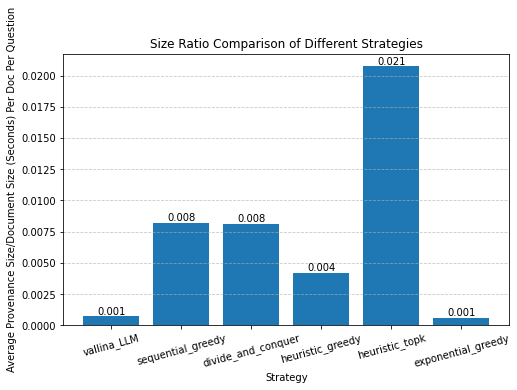

In [18]:
#provenance size vs document size 

y = {}

for strategy in strategies:
    total_provenance_size = 0
    total_context_size = 0
    for o in runs[strategy]:
        #print(o['path'])
        if 'provenance_size' in o:
            total_provenance_size += o['provenance_size']
        else:
            provenance_size = count_tokens("".join(o['provenance']))
            total_provenance_size += provenance_size
            #print(provenance_size)
        total_context_size += o['context_size']
    
    size_ratio = total_provenance_size/total_context_size
    y[strategy] = size_ratio/len(runs[strategy])

# Extracting x (strategies) and y (costs)
strategies = ['vallina_LLM','sequential_greedy','divide_and_conquer','heuristic_greedy','heuristic_topk','exponential_greedy']
y_values = [y[strategy] for strategy in strategies]

# Plotting the bar chart with value labels
plt.figure(figsize=(8, 5))
bars = plt.bar(strategies, y_values)

# Adding labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

# Adding labels and title
plt.xlabel("Strategy")
plt.ylabel("Average Provenance Size/Document Size (Seconds) Per Doc Per Question")
plt.title("Size Ratio Comparison of Different Strategies")

# Rotate x labels for better readability
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.savefig(parent_directory + "/out/papers/plots/size_gpt4omini.jpg", dpi=300, bbox_inches='tight')
# Show plot
plt.show()

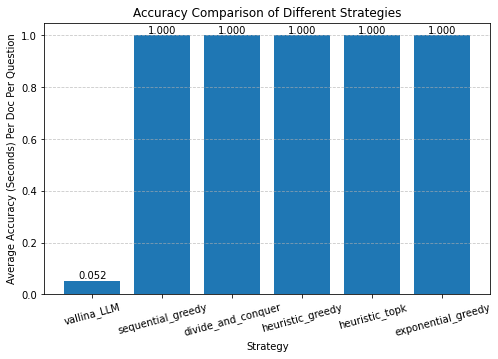

In [19]:
#accuracy 
y = {}

for strategy in strategies:
    accuracy = 0
    if strategy == 'vallina_LLM':
        accuracy = 0.63
        # for o in runs[strategy]:
        #     #print(o['path'])
        #     answers = o['answers']
        #     if isinstance(o['provenance'], list):
        #         provenance = "".join(o['provenance'])
        #     else:
        #         provenance = o['provenance']
        #     question = o['question']
        #     eval, in_tokens, out_tokens = base_strategies.evaluate(answers, question, [],[], context=provenance)
        #     if eval:
        #         accuracy += 1
    else:
        accuracy = len(runs[strategy])

    #print(strategy, accuracy, len(runs[strategy]))
    
    y[strategy] = accuracy/len(runs[strategy])

# Extracting x (strategies) and y (costs)
strategies = ['vallina_LLM','sequential_greedy','divide_and_conquer','heuristic_greedy','heuristic_topk','exponential_greedy']
y_values = [y[strategy] for strategy in strategies]

# Plotting the bar chart with value labels
plt.figure(figsize=(8, 5))
bars = plt.bar(strategies, y_values)

# Adding labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

# Adding labels and title
plt.xlabel("Strategy")
plt.ylabel("Average Accuracy (Seconds) Per Doc Per Question")
plt.title("Accuracy Comparison of Different Strategies")

# Rotate x labels for better readability
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.savefig(parent_directory + "/out/papers/plots/accuracy_gpt4omini.jpg", dpi=300, bbox_inches='tight')
# Show plot
plt.show()

In [20]:
#hotpot dataset 
data_path = parent_directory + '/out/hotpotQA/results/'
strategies = ['vallina_LLM','sequential_greedy','divide_and_conquer','heuristic_greedy','heuristic_topk','exponential_greedy']


q_num = 12
runs = {}
for q_id in range(q_num):
    #this is one run 
    for strategy in strategies:
        file_path = data_path + 'hotpot' + '_q' + str(q_id) + '_' + strategy + '.json'
        result = read_json(file_path)
        if strategy not in runs:
            runs[strategy] = []
        runs[strategy].append(result) 




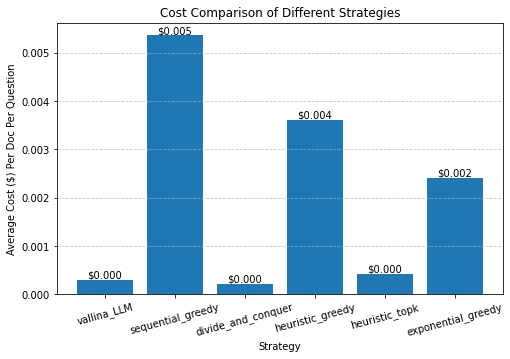

In [21]:
#hotpot cost

y = {}
input_cost_unit = 0.15/1000000
output_cost_unit = 0.6/1000000

for strategy in strategies:
    total_input_tokens = 0
    total_output_tokens = 0
    for o in runs[strategy]:
        tokens = o['tokens']
        total_input_tokens += tokens[0]
        total_output_tokens += tokens[1]
    #compute cost 
    total_cost = total_input_tokens*input_cost_unit + total_output_tokens*output_cost_unit
    y[strategy] = total_cost/len(runs[strategy])

# Extracting x (strategies) and y (costs)
strategies = ['vallina_LLM','sequential_greedy','divide_and_conquer','heuristic_greedy','heuristic_topk','exponential_greedy']
y_values = [y[strategy] for strategy in strategies]

# Plotting the bar chart with value labels
plt.figure(figsize=(8, 5))
bars = plt.bar(strategies, y_values)

# Adding labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'${yval:.3f}', ha='center', va='bottom', fontsize=10)

# Adding labels and title
plt.xlabel("Strategy")
plt.ylabel("Average Cost ($) Per Doc Per Question")
plt.title("Cost Comparison of Different Strategies")

# Rotate x labels for better readability
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig(parent_directory + "/out/hotpotQA/plots/cost_gpt4omini.jpg", dpi=300, bbox_inches='tight')
# Show plot
plt.show()

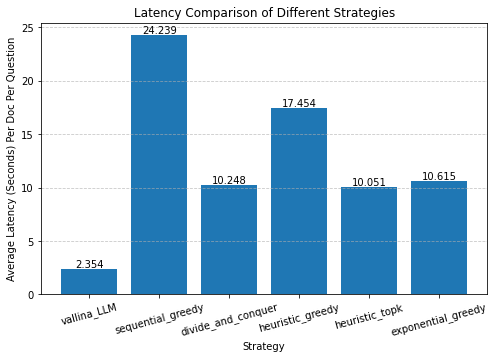

In [22]:
#latency

y = {}

for strategy in strategies:
    total_time = 0
    for o in runs[strategy]:
        latency = o['time']
        total_time += latency
    #compute cost 
    y[strategy] = total_time/len(runs[strategy])

# Extracting x (strategies) and y (costs)
strategies = ['vallina_LLM','sequential_greedy','divide_and_conquer','heuristic_greedy','heuristic_topk','exponential_greedy']
y_values = [y[strategy] for strategy in strategies]

# Plotting the bar chart with value labels
plt.figure(figsize=(8, 5))
bars = plt.bar(strategies, y_values)

# Adding labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

# Adding labels and title
plt.xlabel("Strategy")
plt.ylabel("Average Latency (Seconds) Per Doc Per Question")
plt.title("Latency Comparison of Different Strategies")

# Rotate x labels for better readability
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.savefig(parent_directory + "/out/hotpotQA/plots/latency_gpt4omini.jpg", dpi=300, bbox_inches='tight')
# Show plot
plt.show()

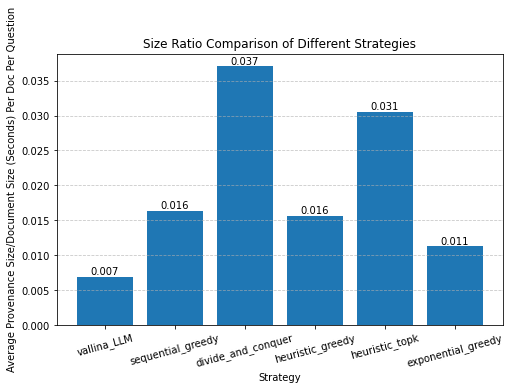

In [23]:
#provenance size vs document size 

y = {}

for strategy in strategies:
    total_provenance_size = 0
    total_context_size = 0
    for o in runs[strategy]:
        #print(o['path'])
        if 'provenance_size' in o:
            total_provenance_size += o['provenance_size']
        else:
            provenance_size = count_tokens("".join(o['provenance']))
            total_provenance_size += provenance_size
            #print(provenance_size)
        total_context_size += o['context_size']
    
    size_ratio = total_provenance_size/total_context_size
    y[strategy] = size_ratio/len(runs[strategy])

# Extracting x (strategies) and y (costs)
strategies = ['vallina_LLM','sequential_greedy','divide_and_conquer','heuristic_greedy','heuristic_topk','exponential_greedy']
y_values = [y[strategy] for strategy in strategies]

# Plotting the bar chart with value labels
plt.figure(figsize=(8, 5))
bars = plt.bar(strategies, y_values)

# Adding labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

# Adding labels and title
plt.xlabel("Strategy")
plt.ylabel("Average Provenance Size/Document Size (Seconds) Per Doc Per Question")
plt.title("Size Ratio Comparison of Different Strategies")

# Rotate x labels for better readability
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.savefig(parent_directory + "/out/hotpotQA/plots/size_gpt4omini.jpg", dpi=300, bbox_inches='tight')
# Show plot
plt.show()

vallina_LLM 0.583 12
sequential_greedy 12 12
divide_and_conquer 12 12
heuristic_greedy 12 12
heuristic_topk 12 12
exponential_greedy 12 12


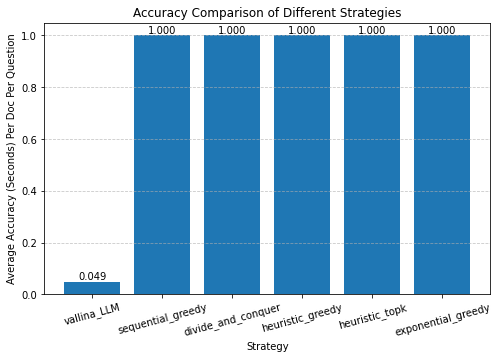

In [24]:
#accuracy 
y = {}

for strategy in strategies:
    accuracy = 0
    if strategy == 'vallina_LLM':
        accuracy = 0.583
        # for o in runs[strategy]:
        #     #print(o['path'])
        #     answers = o['answers']
        #     if isinstance(o['provenance'], list):
        #         provenance = "".join(o['provenance'])
        #     else:
        #         provenance = o['provenance']
        #     question = o['question']
        #     eval, in_tokens, out_tokens = base_strategies.evaluate(answers, question, [],[], context=provenance)
        #     if eval:
        #         accuracy += 1
    else:
        accuracy = len(runs[strategy])

    print(strategy, accuracy, len(runs[strategy]))
    
    y[strategy] = accuracy/len(runs[strategy])

# Extracting x (strategies) and y (costs)
strategies = ['vallina_LLM','sequential_greedy','divide_and_conquer','heuristic_greedy','heuristic_topk','exponential_greedy']
y_values = [y[strategy] for strategy in strategies]

# Plotting the bar chart with value labels
plt.figure(figsize=(8, 5))
bars = plt.bar(strategies, y_values)

# Adding labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

# Adding labels and title
plt.xlabel("Strategy")
plt.ylabel("Average Accuracy (Seconds) Per Doc Per Question")
plt.title("Accuracy Comparison of Different Strategies")

# Rotate x labels for better readability
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.savefig(parent_directory + "/out/hotpotQA/plots/accuracy_gpt4omini.jpg", dpi=300, bbox_inches='tight')
# Show plot
plt.show()

In [9]:

def write_json(data, file):
    with open(file, "w", encoding="utf-8") as file:
        json.dump(data, file, indent=4)  # `indent=4` makes it human-readable

In [ ]:
#monotonicity paper 
data_path = parent_directory + '/data/papers.json'
result_path = parent_directory + '/out/papers/results/'
#read paper data objects 
paper_objects = base_strategies.data_digestion.digest_paper_dataset(data_path)
strategies = ['vallina_LLM','sequential_greedy','divide_and_conquer','heuristic_greedy']

#read paper result objects 
doc_num = 4
q_num = 3
runs = {}
for d_id in range(doc_num):
    for q_id in range(q_num):
        #this is one run 
        for strategy in strategies:
            file_path = result_path + 'doc' + str(d_id) + '_q' + str(q_id) + '_' + strategy + '.json'
            result = read_json(file_path)
            if strategy not in runs:
                runs[strategy] = []
            runs[strategy].append(result) 



In [5]:
def test_monotonicity(total_size, ids, sentences, question, answers, round = 100):
    remaining_ids = []
    for i in range(total_size):
        if i in ids:
            continue
        remaining_ids.append(i)
    current_ids = ids
    miss_cnt = 0
    for i in range(min(round, len(remaining_ids))):
        #every time add one sentence
        current_ids.append(remaining_ids[i])
        eval, in_tokens, out_tokens = base_strategies.evaluate(answers, question, current_ids, sentences, metric = 'LLM')
        if not eval: 
            miss_cnt += 1
    return miss_cnt, min(round, len(remaining_ids))

In [6]:
doc_num = 5

mono_records = {}

for p_id in range(len(paper_objects)):
    paper = paper_objects[p_id]
    if(p_id >= doc_num):
        break
    text = paper['text']
    title = paper['title']
    print(title)
    sentences = base_strategies.extract_sentences_from_pdf(text)

    #find the the provenance of sequential greedy with the same title 
    for o in runs['sequential_greedy']:
        if o['title'] == title:
            ids = o['provenance_ids']
            provenance = o['provenance']
            context = ''.join(provenance)
            question = o['question']
            answers, in_tokens, out_tokens = base_strategies.QA(question, context)#this is the answer from current provenance
            miss_cnt, total_round = test_monotonicity(len(sentences), ids, sentences, question, answers, round = 100)
            print(miss_cnt, total_round)
            mono_records[title] = (miss_cnt, total_round, (total_round - miss_cnt)/total_round)
            break

write_json(mono_records, parent_directory + '/out/papers/plots/monotonicity.json')

NameError: name 'paper_objects' is not defined

"I Don't Understand..." Issues in Self-Quantifying Commuting
0 100
Expense Control: A Gamified, Semi-Automated, Crowd-Based Approach For Receipt Capturing
0 100
Understanding My Data, Myself: Supporting Self-reflection with Ubicomp Technologies
0 100
Sundroid: Solar Radiation Awareness with Smartphones
0 100

In [14]:
def test_consistency(text, question, answers, round = 50):
    miss_cnt = 0
    for i in range(round):
        eval, in_tokens, out_tokens = base_strategies.evaluate(answers, question, [], [], context=text)
        if not eval:
            miss_cnt += 1
    return miss_cnt, round 

In [ ]:
#paper consistency 
doc_num = 5

consistency_records = {}

for p_id in range(len(paper_objects)):
    paper = paper_objects[p_id]
    if(p_id >= doc_num):
        break
    text = paper['text']
    title = paper['title']
    print(title)
    sentences = base_strategies.extract_sentences_from_pdf(text)

    #find the the provenance of sequential greedy with the same title 
    for o in runs['sequential_greedy']:
        if o['title'] == title:
            question = o['question']
            answers, in_tokens, out_tokens = base_strategies.QA(question, text)#this is the answer from current provenance
            miss_cnt, total_round = test_consistency(text, question, answers, round = 50)
            print(miss_cnt, total_round)
            consistency_records[title] = (miss_cnt, total_round, (total_round - miss_cnt)/total_round)
            break

write_json(consistency_records, parent_directory + '/out/papers/plots/consistency.json')

"I Don't Understand..." Issues in Self-Quantifying Commuting
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
['2019']
1 1
True
0 50
Expense Control: A Gamified, Semi-

"I Don't Understand..." Issues in Self-Quantifying Commuting
0 50
Expense Control: A Gamified, Semi-Automated, Crowd-Based Approach For Receipt Capturing
0 50
Understanding My Data, Myself: Supporting Self-reflection with Ubicomp Technologies
0 50
Sundroid: Solar Radiation Awareness with Smartphones
0 50

In [17]:
#hotpot monotonicity 

data_path = parent_directory + '/data/hotpotQA_fullwiki.json'
result_path = parent_directory + '/out/hotpotQA/results/'
#read paper data objects 
hotpot_objects = base_strategies.data_digestion.digest_hotpotQA_dataset(data_path)
strategies = ['vallina_LLM','sequential_greedy','divide_and_conquer','heuristic_greedy']

#read hotpot result objects 
doc_num = 12
runs = {}
for d_id in range(doc_num):
        #this is one run 
        for strategy in strategies:
            file_path = result_path + 'hotpot' + '_q' + str(d_id) + '_' + strategy + '.json'
            result = read_json(file_path)
            if strategy not in runs:
                runs[strategy] = []
            runs[strategy].append(result) 


In [18]:

mono_records = {}
i = 0
num_of_case = 10

for e in hotpot_objects:
    i += 1
    q = e['question']
    instruction = e['instruction']
    question = (q, instruction)
    text = e['context']
    sentences = base_strategies.extract_sentences_from_pdf(text)
    
    # if q != 'Who is older, Annie Morton or Terry Richardson?':
    #      continue
    
    if(i > num_of_case):
        break

    #find the the provenance of sequential greedy with the same question  
    for o in runs['sequential_greedy']:
        #print(o['question'])
        if o['question'][0] == question[0]:
            print(question)
            if question[0] != 'What science fantasy young adult series, told in first person, has a set of companion books narrating the stories of enslaved worlds and alien species?':
                continue
            ids = o['provenance_ids']
            provenance = o['provenance']
            context = ''.join(provenance)
            answers, in_tokens, out_tokens = base_strategies.QA(question, context)#this is the answer from current provenance
            print(answers)
            miss_cnt, total_round = test_monotonicity(len(sentences), ids, sentences, question, answers, round = 100)
            print(miss_cnt, total_round)
            mono_records[question[0]] = (miss_cnt, total_round, (total_round - miss_cnt)/total_round)
            

#write_json(mono_records, parent_directory + '/out/hotpotQA/plots/monotonicity.json')

('Were Scott Derrickson and Ed Wood of the same nationality?', 'Only return yes or no. Do not add explanations.')
('What government position was held by the woman who portrayed Corliss Archer in the film Kiss and Tell?', 'Only return the answer. Do not add explanations.')
('What science fantasy young adult series, told in first person, has a set of companion books narrating the stories of enslaved worlds and alien species?', 'Only return the answer. Do not add explanations.')
['The "Starbound" trilogy by Amie Kaufman and Meagan Spooner.']
['The "Parable" series by Octavia Butler.']
1 1
False
['The "Starbound" series by Amie Kaufman and Meagan Spooner.']
1 1
True
['The "Parable" series by Octavia Butler.']
1 1
False
['The "Parable" series by Octavia Butler.']
1 1
False
['The "Starbound" trilogy by Amie Kaufman and Meagan Spooner.']
1 1
True
['The "Parable" series by Octavia Butler.']
1 1
False
['The "Parable" series by Octavia Butler.']
1 1
False
['The "Starbound" trilogy by Amie Kaufma

In [13]:
mono_objects = read_json('/Users/yiminglin/Documents/Codebase/doc-provenance/out/hotpotQA/plots/monotonicity.json')
avg_mono = 0
for key, values in mono_objects.items():
    avg_mono += values[2]
    print(values[2])
avg_mono /= len(mono_objects)
avg_mono

1
0.89
0.59
1
1.0
0.9318181818181818
1.0
0.9552238805970149
0.6956521739130435
0.9787234042553191


0.904141764058356

In [42]:
#hotpot consistency 
num_of_case = 10

consistency_records = {}
i = -1
for e in hotpot_objects:
    i += 1
    q = e['question']
    instruction = e['instruction']
    question = (q, instruction)
    if q != 'The arena where the Lewiston Maineiacs played their home games can seat how many people?':
        continue
    text = e['context']
    answers, in_tokens, out_tokens = base_strategies.QA(question, text)#this is the answer from current provenance
    miss_cnt, total_round = test_consistency(text, question, answers, round = 50)
    print(miss_cnt, total_round)
    consistency_records[q] = (miss_cnt, total_round, (total_round - miss_cnt)/total_round)
    if(i > num_of_case):
        break

#write_json(consistency_records, parent_directory + '/out/hotpotQA/plots/consistency.json')

['3,500']
1 1
True
['3,200']
1 1
False
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
['3,500']
1 1
True
1 50
